<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
# !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

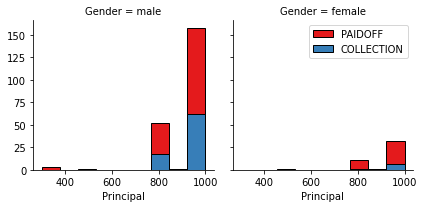

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

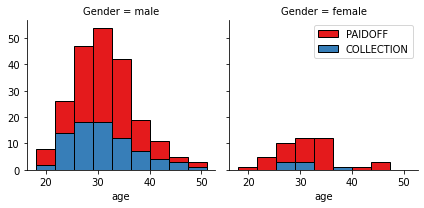

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


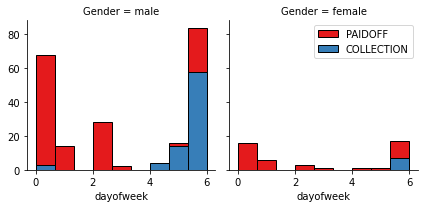

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

<hr>
<h1 style="color:red">----- FOR ASSIGNMENT ----- AFTER THIS LINE -----</h1>
<hr>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [21]:
from sklearn.neighbors import KNeighborsClassifier

# LABEL ENCODING FOR LOAN_STATUS!
lo_stat = LabelEncoder()
lo_stat.fit(df['loan_status'].unique())
y[:] = lo_stat.transform(y[:])

y = y.astype('int')
y[0:5]

array([1, 1, 1, 1, 1])

In [22]:
# train/test splitting...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [23]:
K = 10
mean_acc = np.zeros((K-1))
std_acc = np.zeros((K-1))

for n in range(1,K): 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    
    mean_acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.64285714, 0.55714286, 0.71428571, 0.62857143, 0.75714286,
       0.65714286, 0.75714286, 0.71428571, 0.7       ])

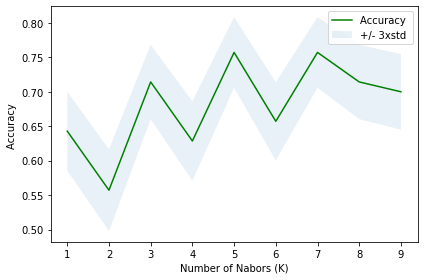

In [24]:
plt.plot(range(1,K),mean_acc,'g')
plt.fill_between(range(1,K),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [25]:
print("OPTIMIM K VALUE:",mean_acc.argmax()+1,"-> Accuracy:", mean_acc.max()) 

OPTIMIM K VALUE: 5 -> Accuracy: 0.7571428571428571


In [26]:
neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_train,y_train)
yhat = neigh.predict(X_test)

print("KNN F1 Score: ", f1_score(y_test, yhat, average='weighted'))

KNN F1 Score:  0.7609440993788821


In [27]:
print("KNN JACCARD Score: ", jaccard_score(y_test, yhat))

KNN JACCARD Score:  0.7424242424242424


# Decision Tree


In [28]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)
tahminTree = loanTree.predict(X_test)

print("Decision Tree Accuracy: ", accuracy_score(y_test, tahminTree))

Decision Tree Accuracy:  0.7


In [29]:
print("Decision Tree F1 Score: ", f1_score(y_test, tahminTree, average='weighted'))

Decision Tree F1 Score:  0.6947603121516165


In [30]:
print("Decision Tree JACCARD Score: ", jaccard_score(y_test, tahminTree))

Decision Tree JACCARD Score:  0.6956521739130435


# Support Vector Machine


In [31]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
print("SVM Accuracy: ", accuracy_score(y_test, yhat))

SVM Accuracy:  0.8


In [32]:
print("SVM F1 Score: ", f1_score(y_test, yhat, average='weighted'))

SVM F1 Score:  0.7365079365079366


In [33]:
print("SVM JACCARD Score: ", jaccard_score(y_test, yhat))

SVM JACCARD Score:  0.8


# Logistic Regression


In [34]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, yhat))

Logistic Regression Accuracy:  0.8142857142857143


In [35]:
print("Logistic Regression F1 Score: ", f1_score(y_test, yhat, average='weighted'))

Logistic Regression F1 Score:  0.7813349730135957


In [36]:
print("Logistic Regression JACCARD Score: ", jaccard_score(y_test, yhat))

Logistic Regression JACCARD Score:  0.8088235294117647


In [37]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

array([[0.45451971, 0.54548029],
       [0.44609603, 0.55390397],
       [0.4718169 , 0.5281831 ],
       [0.49172395, 0.50827605],
       [0.33832495, 0.66167505]])

In [38]:
from sklearn.metrics import log_loss
print("Logistic Regression LOG LOSS: ",log_loss(y_test, yhat_prob))

Logistic Regression LOG LOSS:  0.5596633457155463


<H1 STYLE="COLOR:RED">--- TEST SET IMPORTING --- FROM THIS LINE ---</H1>

# Model Evaluation using Test set


In [39]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [40]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [41]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [42]:
# data pre-processing...

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# work out education level
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)

# normalize the test data
test_X = preprocessing.StandardScaler().fit(test_feature).transform(test_feature)
test_y = test_df['loan_status'].values
test_y[0:5]


# LABEL ENCODING FOR LOAN_STATUS!
lo_stat = LabelEncoder()
lo_stat.fit(test_df['loan_status'].unique())
test_y[:] = lo_stat.transform(test_y[:])
test_y = test_y.astype('int')
test_y[0:5]


array([1, 1, 1, 1, 1])

## KNN

In [43]:
yhat = neigh.predict(test_X)
knn_jaccard = jaccard_score(test_y, yhat)
knn_jaccard

0.6938775510204082

In [44]:
knn_f1 = f1_score(test_y, yhat, average='weighted')
knn_f1

0.7105756358768406

## Decision Tree

In [45]:
dTree = loanTree.predict(test_X)
dt_jaccard = jaccard_score(test_y, dTree)
dt_jaccard

0.75

In [46]:
dt_f1 = f1_score(test_y, dTree, average='weighted')
dt_f1

0.7645502645502646

## SVM

In [47]:
yhat = clf.predict(test_X)
svm_jaccard = jaccard_score(test_y, yhat)
svm_jaccard

0.6981132075471698

In [48]:
svm_f1 = f1_score(test_y, yhat, average='weighted')
svm_f1

0.6378600823045267

## Logistic Regression

In [49]:
yhat = LR.predict(test_X)
LR_jaccard = jaccard_score(test_y, yhat)
LR_jaccard

0.7647058823529411

In [50]:
LR_f1 = f1_score(test_y, yhat, average='weighted')
LR_f1

0.7283950617283951

In [51]:
yhat_probA = LR.predict_proba(test_X)
LR_log_loss = log_loss(test_y, yhat_probA)
LR_log_loss 

0.5683377322713342

<hr>

<h1 style="color:RED">FINAL REPORT TABLE</h1>

In [52]:
report = pd.DataFrame(columns=['Algorithm','Jaccard','F1-score','LogLoss'])
report

,Algorithm,Jaccard,F1-score,LogLoss


In [53]:
report['Algorithm'] = ['KNN','Decision Tree','SVM','Logistic Regression']
report['Jaccard'] = [knn_jaccard, dt_jaccard, svm_jaccard, LR_jaccard]
report['F1-score'] = [knn_f1, dt_f1, svm_f1, LR_f1]
report['LogLoss'] = ['NA', 'NA', 'NA', LR_log_loss]
report.set_index('Algorithm')

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.693878,0.710576,NA
Decision Tree,0.750000,0.764550,NA
SVM,0.698113,0.637860,NA
Logistic Regression,0.764706,0.728395,0.568338


<h3>Thanks...</h3>